In [ ]:
# from psfsynth import *
# inst = 1
# ifield = 4-8
# filt_order = 3
# run_psf_synth(inst,ifield, filt_order=filt_order)
# profdat = run_psf_combine(inst, ifield)

Text(0, 0.5, 'I [$mW/m^2/sr$]')

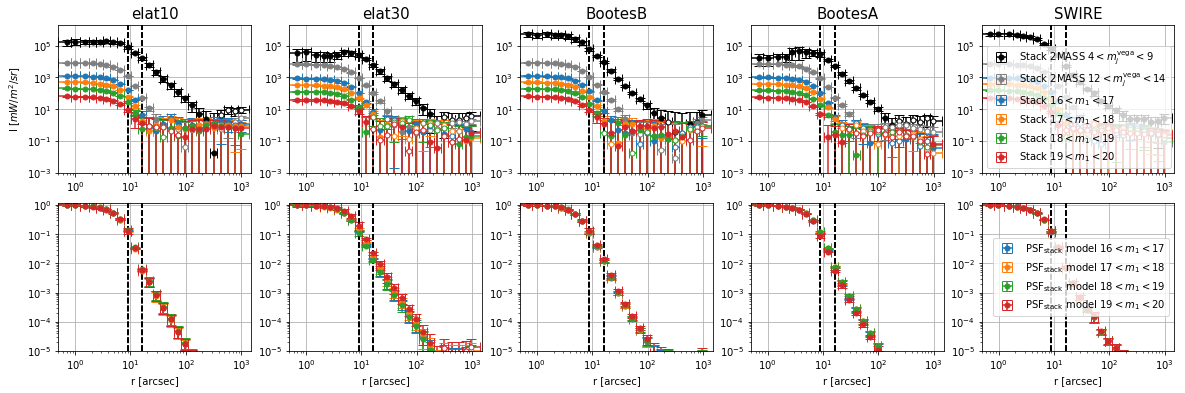

In [36]:
from psfstack import *

inst = 1
fig, ax = plt.subplots(2, 5, figsize = (20,6))
for i,ifield in enumerate([4,5,6,7,8]):
    fname = mypaths['alldat'] + 'TM'+ str(inst) + \
    '/psfdata_synth_%s.pkl'%(fieldnamedict[ifield])
    with open(fname, "rb") as f:
        profdat = pickle.load(f)
        
    plot_err_log(profdat['rbins'], 
                 profdat['out']['profcb'],
                 profdat['out']['profcb_err'],
                 ax=ax[0][i], color='k',label=r'Stack 2MASS $4 < m_j^{\rm vega} < 9$')
    
    plot_err_log(profdat['rbins'], 
                 profdat['mid']['profcb'],
                 profdat['mid']['profcb_err'],
                 ax=ax[0][i], color='grey',label=r'Stack 2MASS $12 < m_j^{\rm vega} < 14$')


    for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
        plot_err_log(profdat['rbins'], 
                     profdat[im]['profcb'],
                     profdat[im]['profcb_err'],
                     ax=ax[0][i], color='C'+str(im),label=r'Stack $%d < m_1 <%d$'%(m_min, m_max))
        plot_err_log(profdat['rbins'], 
                     profdat[im]['comb']['profcb'],
                     profdat[im]['comb']['profcb_err'],
                     ax=ax[1][i], color='C'+str(im),
                     label=r'PSF$_{\rm stack}$ model $%d < m_1 <%d$'%(m_min, m_max))
        
        ax[0][i].axvline(profdat['rbins'][8],c='k',ls='--')
        ax[0][i].axvline(profdat['rbins'][10],c='k',ls='--')
        ax[1][i].axvline(profdat['rbins'][8],c='k',ls='--')
        ax[1][i].axvline(profdat['rbins'][10],c='k',ls='--')
        
    ax[0][i].set_ylim([1e-3,2e6])
    ax[0][i].set_xlim([5e-1,1.5e3])
    ax[0][i].grid()    
    ax[0][i].set_title(fieldnamedict[ifield], fontsize=15)
    ax[1][i].set_ylim([1e-5,1.2])
    ax[1][i].set_xlim([5e-1,1.5e3])
    ax[1][i].grid() 
    ax[-1][i].set_xlabel('r [arcsec]')
ax[0][-1].legend()
ax[1][-1].legend()
ax[0][0].set_ylabel('I [$mW/m^2/sr$]')

### Compare to the old matlab results

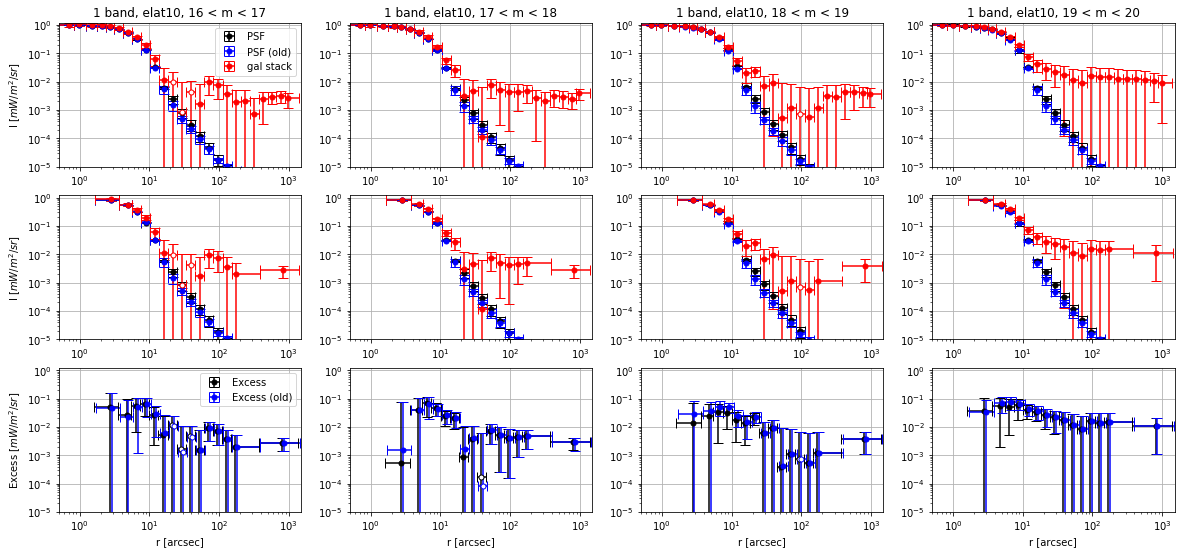

In [41]:
from stack import * 
from psfstack import *

inst = 1
ifield = 4

fname = mypaths['alldat'] + 'TM'+ str(inst) + \
'/psfdata_synth_%s.pkl'%(fieldnamedict[ifield])
with open(fname, "rb") as f:
    profdat = pickle.load(f)

import json
loaddir = mypaths['alldat']+'TM' + str(inst) + '/'
with open(loaddir + fieldnamedict[ifield] + '_datafit.json') as json_file:
    data_all = json.load(json_file)

fig, ax = plt.subplots(3, 4, figsize = (20,9))
for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
        
    plot_err_log(profdat['rbins'], 
                 profdat[im]['comb']['profcb'],
                 profdat[im]['comb']['profcb_err'],
                 ax=ax[0][im], color='k',label='PSF')
    
    plot_err_log(profdat['rsubbins'], 
                 profdat[im]['comb']['profcbsub'],
                 profdat[im]['comb']['profcbsub_err'],
                 ax=ax[1][im], color='k')
    
    # old data
    data = data_all[im]
    scalecb = np.array(data['profgfull'])[0]
    plot_err_log(profdat['rbins'], 
                 np.array(data['profpsfcbfull']),
                 np.sqrt(np.diag(data['covpsfcbfull']))/scalecb,
                 ax=ax[0][im], color='b',label='PSF (old)')
    plot_err_log(profdat['rsubbins'], 
                 np.array(data['profpsfcb']),
                 np.sqrt(np.diag(data['covpsfcb']))/scalecb,
                 ax=ax[1][im], color='b')
    
    # gal
    stackdat = stacking(inst,ifield,m_min,m_max,filt_order=3,
                        load_from_file=True, BGsub=False).stackdat
    scaleg = stackdat['BGsub']['profcb'][0]
    plot_err_log(profdat['rbins'], 
                 stackdat['BGsub']['profcb']/scaleg,
                 np.sqrt(np.diag(stackdat['excov']['profcb']))/scaleg,
                 ax=ax[0][im], color='r',label='gal stack')
    plot_err_log(profdat['rsubbins'], 
                 stackdat['BGsub']['profcbsub']/scaleg,
                 np.sqrt(np.diag(stackdat['excov']['profcbsub']))/scaleg,
                 ax=ax[1][im], color='r')
    
    ex = stackdat['BGsub']['profcbsub']/scaleg - profdat[im]['comb']['profcbsub']
    ex_err = np.sqrt(np.diag(stackdat['excov']['profcbsub'])/scaleg**2 +\
                     profdat[im]['comb']['profcbsub_err']**2)
    plot_err_log(profdat['rsubbins']*0.97, 
                 ex,
                 ex_err,
                 ax=ax[2][im], color='k',label='Excess') 
    
    ex = stackdat['BGsub']['profcbsub']/scaleg - np.array(data['profpsfcb'])
    ex_err = np.sqrt(np.diag(stackdat['excov']['profcbsub'])/scaleg**2 +\
                     np.diag(data['covpsfcb'])/scalecb**2)
    
    plot_err_log(profdat['rsubbins']*1.03, 
                 ex,
                 ex_err,
                 ax=ax[2][im], color='b',label='Excess (old)')

    ax[0][im].set_ylim([1e-5,1.2])
    ax[0][im].set_xlim([5e-1,1.5e3])
    ax[0][im].grid()    
    ax[1][im].set_ylim([1e-5,1.2])
    ax[1][im].set_xlim([5e-1,1.5e3])
    ax[1][im].grid()    
    ax[2][im].set_ylim([1e-5,1.2])
    ax[2][im].set_xlim([5e-1,1.5e3])
    ax[2][im].grid()
    ax[0][im].set_title('band %d, %s, %d < m < %d'%(inst, fieldnamedict[ifield],m_min, m_max))
    ax[-1][im].set_xlabel('r [arcsec]')
ax[0][0].set_ylabel('I [$mW/m^2/sr$]')
ax[1][0].set_ylabel('I [$mW/m^2/sr$]')
ax[2][0].set_ylabel('Excess [$mW/m^2/sr$]')

ax[0][0].legend()
ax[2][0].legend()